In [130]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from statsmodels import api as sm
import plotly.subplots as sp
import math
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Dropout
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import SGD

warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8-darkgrid")


Dataset Overview

In [131]:
df_ibm = pd.read_csv('data\IBM_2006-01-01_to_2018-01-01.csv')
df_ibm.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
1,2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2,2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
3,2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
4,2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


In [132]:
df_ibm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3020 entries, 0 to 3019
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3020 non-null   object 
 1   Open    3019 non-null   float64
 2   High    3020 non-null   float64
 3   Low     3019 non-null   float64
 4   Close   3020 non-null   float64
 5   Volume  3020 non-null   int64  
 6   Name    3020 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 165.3+ KB


In [133]:
df_ibm.describe()

,Open,High,Low,Close,Volume
count,3019.000000,3020.000000,3019.000000,3020.000000,3.020000e+03
mean,145.515545,146.681738,144.471597,145.617278,5.773301e+06
std,37.554946,37.613446,37.477641,37.529387,3.192831e+06
min,72.740000,73.940000,69.500000,71.740000,2.542560e+05
25%,116.405000,117.765000,115.490000,116.525000,3.622681e+06
50%,149.610000,150.330000,148.470000,149.315000,4.928852e+06
75%,178.445000,179.762500,177.330000,178.685000,6.965014e+06
max,215.380000,215.900000,214.300000,215.800000,3.077428e+07


In [134]:
df_ibm.isnull().sum()

Date      0
Open      1
High      0
Low       1
Close     0
Volume    0
Name      0
dtype: int64

In [135]:
df_ibm.dropna(inplace=True)

In [136]:
df_ibm['Date'] = pd.to_datetime(df_ibm['Date'])

Seasonal Decomposition

In [137]:
df_ibm.set_index('Date', inplace=True)

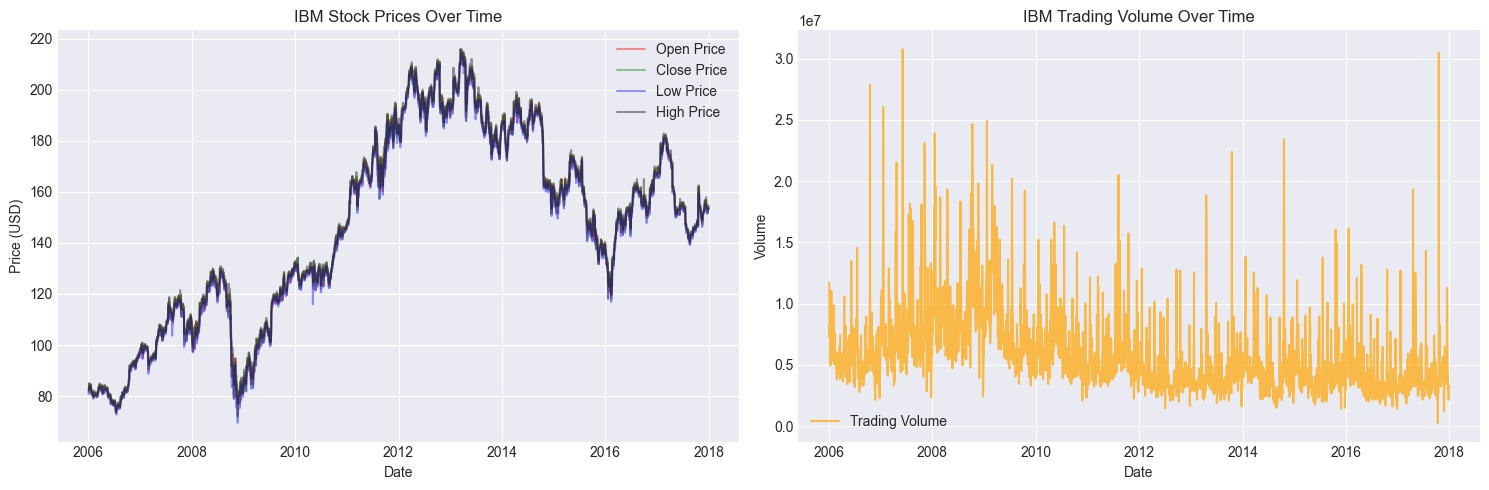

In [138]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(df_ibm['Open'], color='red', label='Open Price', alpha=0.4)
plt.plot(df_ibm['Close'], color='green', label='Close Price', alpha=0.4)
plt.plot(df_ibm['Low'], color='blue', label='Low Price', alpha=0.4)
plt.plot(df_ibm['High'], color='black', label='High Price', alpha=0.4)
plt.title('IBM Stock Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.plot(df_ibm['Volume'], color='orange', label='Trading Volume', alpha=0.7)
plt.title('IBM Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

In [139]:
decomposition_result = seasonal_decompose(df_ibm['Close'], model='additive', period=365)
subplot_titles = ['Observed Prices', 'Trend Component', 'Seasonal Component', 'Residuals']
fig = sp.make_subplots(rows=4, cols=1, shared_xaxes=True, subplot_titles=subplot_titles)
fig.add_trace(go.Scatter(x=df_ibm.index, y=decomposition_result.observed, 
                         mode='lines', name='Observed Prices',
                         line=dict(color='blue', width=2)), row=1, col=1)
fig.add_trace(go.Scatter(x=df_ibm.index, y=decomposition_result.trend, 
                         mode='lines', name='Trend',
                         line=dict(color='orange', width=2)), row=2, col=1)
fig.add_trace(go.Scatter(x=df_ibm.index, y=decomposition_result.seasonal, 
                         mode='lines', name='Seasonal',
                         line=dict(color='green', width=2)), row=3, col=1)
fig.add_trace(go.Scatter(x=df_ibm.index, y=decomposition_result.resid, 
                         mode='lines', name='Residual',
                         line=dict(color='red', width=2)), row=4, col=1)
fig.update_layout(height=800, title='Decomposed Analysis of Closing Prices of IBM',
                  xaxis_title='Date', yaxis_title='Value', showlegend=True)
fig.show()


Data Preprocessing and Time Series Preparation for LSTM/GRU/RNN Models

In [140]:
df_ibm.drop(['Name'], axis=1, inplace=True)

In [141]:
df_ibm.head()

,Open,High,Low,Close,Volume
Date,,,,,
2006-01-03,82.45,82.55,80.81,82.06,11715200
2006-01-04,82.20,82.50,81.33,81.95,9840600
2006-01-05,81.40,82.90,81.00,82.50,7213500
2006-01-06,83.95,85.03,83.41,84.95,8197400
2006-01-09,84.10,84.25,83.38,83.73,6858200


In [142]:
def return_rmse(test, predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("the root mean squared error is : {}.".format(rmse))

In [143]:
'''
train = df_ibm[:'2016'].iloc[:,1:2].values
test = df_ibm['2017':].iloc[:,1:2].values
train
'''

"\ntrain = df_ibm[:'2016'].iloc[:,1:2].values\ntest = df_ibm['2017':].iloc[:,1:2].values\ntrain\n"

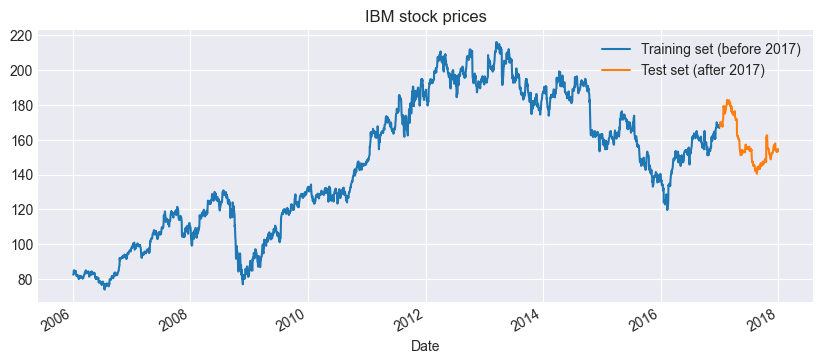

In [144]:
df_ibm["High"][:'2016'].plot(figsize=(10,4), legend=True)
df_ibm["High"]["2017":].plot(figsize=(10,4), legend=True)
plt.legend(["Training set (before 2017)", "Test set (after 2017)"])
plt.title("IBM stock prices")
plt.show()

In [145]:
'''
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train)
'''

'\nscaler = MinMaxScaler(feature_range=(0, 1))\ntrain_scaled = scaler.fit_transform(train)\n'

In [146]:
'''
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)
'''

'\ndef create_dataset(data, time_step=1):\n    X, y = [], []\n    for i in range(len(data) - time_step - 1):\n        X.append(data[i:(i + time_step), 0])\n        y.append(data[i + time_step, 0])\n    return np.array(X), np.array(y)\n'

In [147]:
'''
time_step = 60
X_train, y_train = create_dataset(train_scaled, time_step)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
'''

'\ntime_step = 60\nX_train, y_train = create_dataset(train_scaled, time_step)\n\nX_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)\n'

In [148]:
'''
def prepare_and_predict(model, data, scaler, time_step):
    """
    Prepares the input data for the model and makes predictions.

    Parameters:
    model: The trained model (e.g., LSTM_model, RNN_model, etc.)
    data: The original data (Pandas DataFrame) to get the high prices from.
    scaler: The scaler used for normalization (MinMaxScaler).
    time_step: The number of time steps to consider for the LSTM/RNN model.

    Returns:
    predicted_prices: The predicted prices after inverse transformation.
    """
    inputs = data["High"][len(data) - len(test) - time_step:].values
    inputs = inputs.reshape(-1, 1)
    inputs = scaler.transform(inputs)

    X_test = []
    for i in range(time_step, len(inputs)):
        X_test.append(inputs[i-time_step:i, 0])
    
    X_test = np.array(X_test)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    predicted_prices = model.predict(X_test)
    predicted_prices = scaler.inverse_transform(predicted_prices)

    return predicted_prices
'''

'\ndef prepare_and_predict(model, data, scaler, time_step):\n    """\n    Prepares the input data for the model and makes predictions.\n\n    Parameters:\n    model: The trained model (e.g., LSTM_model, RNN_model, etc.)\n    data: The original data (Pandas DataFrame) to get the high prices from.\n    scaler: The scaler used for normalization (MinMaxScaler).\n    time_step: The number of time steps to consider for the LSTM/RNN model.\n\n    Returns:\n    predicted_prices: The predicted prices after inverse transformation.\n    """\n    inputs = data["High"][len(data) - len(test) - time_step:].values\n    inputs = inputs.reshape(-1, 1)\n    inputs = scaler.transform(inputs)\n\n    X_test = []\n    for i in range(time_step, len(inputs)):\n        X_test.append(inputs[i-time_step:i, 0])\n    \n    X_test = np.array(X_test)\n    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)\n\n    predicted_prices = model.predict(X_test)\n    predicted_prices = scaler.inverse_transform(predic

In [149]:
'''
LSTM_model = Sequential()
LSTM_model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1)))  
LSTM_model.add(Dropout(0.3)) 
LSTM_model.add(LSTM(units=100, return_sequences=True))  
LSTM_model.add(Dropout(0.3))  
LSTM_model.add(LSTM(units=100, return_sequences=False))  
LSTM_model.add(Dropout(0.3))  
LSTM_model.add(Dense(units=1))
'''

'\nLSTM_model = Sequential()\nLSTM_model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1)))  \nLSTM_model.add(Dropout(0.3)) \nLSTM_model.add(LSTM(units=100, return_sequences=True))  \nLSTM_model.add(Dropout(0.3))  \nLSTM_model.add(LSTM(units=100, return_sequences=False))  \nLSTM_model.add(Dropout(0.3))  \nLSTM_model.add(Dense(units=1))\n'

In [150]:
'''
LSTM_model.compile(optimizer='adam', loss='mean_squared_error')

LSTM_model.fit(X_train, y_train, epochs=15, batch_size=32) 
'''

"\nLSTM_model.compile(optimizer='adam', loss='mean_squared_error')\n\nLSTM_model.fit(X_train, y_train, epochs=15, batch_size=32) \n"

In [151]:
'''
predicted_prices = prepare_and_predict(LSTM_model, df_ibm, scaler, time_step)

plt.figure(figsize=(14, 5))
plt.plot(df_ibm.loc['2017':].index, test, color='blue', label=' IBM Actual Prices')
plt.plot(df_ibm.loc['2017':].index, predicted_prices, color='red', label='IBM Predicted Prices')
plt.title(" IBM Stock Predicted Prices vs Actual Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

return_rmse(test, predicted_prices)
'''

'\npredicted_prices = prepare_and_predict(LSTM_model, df_ibm, scaler, time_step)\n\nplt.figure(figsize=(14, 5))\nplt.plot(df_ibm.loc[\'2017\':].index, test, color=\'blue\', label=\' IBM Actual Prices\')\nplt.plot(df_ibm.loc[\'2017\':].index, predicted_prices, color=\'red\', label=\'IBM Predicted Prices\')\nplt.title(" IBM Stock Predicted Prices vs Actual Prices")\nplt.xlabel("Date")\nplt.ylabel("Price")\nplt.legend()\nplt.show()\n\nreturn_rmse(test, predicted_prices)\n'

In [152]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Layer
import tensorflow as tf
from keras.callbacks import EarlyStopping

# ======================
# 1. DATA PREPARATION
# ======================
def compute_technical_indicators(df):
    """Add technical indicators to dataframe"""
    # Moving Averages
    df['MA_10'] = df['Close'].rolling(window=10).mean()
    df['MA_50'] = df['Close'].rolling(window=50).mean()
    
    # RSI
    delta = df['Close'].diff(1)
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # Bollinger Bands
    df['Upper_Band'] = df['MA_10'] + 2*df['Close'].rolling(window=20).std()
    df['Lower_Band'] = df['MA_10'] - 2*df['Close'].rolling(window=20).std()
    
    # Volume Indicators
    df['Volume_MA_10'] = df['Volume'].rolling(window=10).mean()
    
    # Daily Returns
    df['Daily_Return'] = df['Close'].pct_change()
    
    return df.dropna()

In [153]:
df_ibm = compute_technical_indicators(df_ibm)


Epoch 1/50
67/67 [==============================] - 14s 122ms/step - loss: 0.0186 - val_loss: 0.0067 - lr: 0.0010
Epoch 2/50
67/67 [==============================] - 7s 100ms/step - loss: 0.0085 - val_loss: 8.4376e-04 - lr: 0.0010
Epoch 3/50
67/67 [==============================] - 7s 108ms/step - loss: 0.0070 - val_loss: 8.0711e-04 - lr: 0.0010
Epoch 4/50
67/67 [==============================] - 7s 106ms/step - loss: 0.0069 - val_loss: 7.9755e-04 - lr: 0.0010
Epoch 5/50
67/67 [==============================] - 7s 109ms/step - loss: 0.0058 - val_loss: 0.0018 - lr: 0.0010
Epoch 6/50
67/67 [==============================] - 7s 106ms/step - loss: 0.0055 - val_loss: 7.8072e-04 - lr: 0.0010
Epoch 7/50
67/67 [==============================] - 7s 108ms/step - loss: 0.0051 - val_loss: 4.8579e-04 - lr: 0.0010
Epoch 8/50
67/67 [==============================] - 7s 107ms/step - loss: 0.0049 - val_loss: 8.8073e-04 - lr: 0.0010
Epoch 9/50
67/67 [==============================] - 8s 112ms/step - los

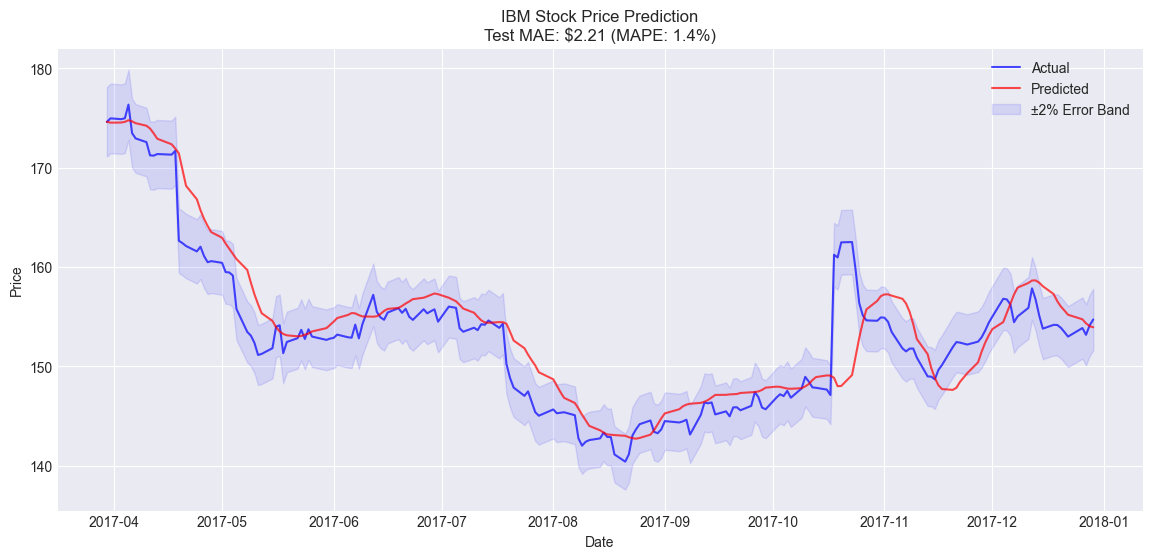

In [26]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# ======================
# 1. IMPROVED FEATURE SELECTION
# ======================
# Select only the most relevant features
price_features = ['Open', 'High', 'Low', 'Close', 'MA_10', 'RSI']    # Removed less important indicators
volume_features = ['Volume']  # Using raw volume instead of MA for more responsiveness
target_feature = 'High'

# ======================
# 2. ENHANCED SCALING STRATEGY
# ======================
# Initialize scalers with tuned parameters
price_scaler = MinMaxScaler(feature_range=(0.1, 0.9))  # Avoids extreme 0/1 values
volume_scaler = RobustScaler(quantile_range=(10, 90))  # More robust to outliers

# Prepare data
train = df_ibm[:'2016'].copy()
test = df_ibm['2017':].copy()

time_step=60

# Scale features with clipping to prevent extreme values
train_prices = price_scaler.fit_transform(train[price_features])
train_volumes = volume_scaler.fit_transform(train[volume_features])
train_scaled = np.concatenate([
    np.clip(train_prices, 0.05, 0.95),  # Soft clipping
    np.clip(train_volumes, -3, 3)       # RobustScaler typically ranges ~[-3,3]
], axis=1)

test_prices = price_scaler.transform(test[price_features])
test_volumes = volume_scaler.transform(test[volume_features])
test_scaled = np.concatenate([
    np.clip(test_prices, 0.05, 0.95),
    np.clip(test_volumes, -3, 3)
], axis=1)

# ======================
# 3. OPTIMIZED DATA PREPARATION
# ======================
def create_sequences(data, targets, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:i+time_step])
        y.append(targets[i+time_step])
    return np.array(X), np.array(y)

# Use the scaled 'High' price as target (column index 1 in price features)
y_train_scaled = train_scaled[:, price_features.index('High')]
y_test_scaled = test_scaled[:, price_features.index('High')]

X_train, y_train = create_sequences(train_scaled, y_train_scaled, time_step=60)
X_test, y_test = create_sequences(test_scaled, y_test_scaled, time_step=60)

# ======================
# 4. IMPROVED MODEL ARCHITECTURE
# ======================
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]),
         recurrent_dropout=0.2),
    Dropout(0.3),
    LSTM(64, return_sequences=True, recurrent_dropout=0.2),
    Dropout(0.3),
    LSTM(32, recurrent_dropout=0.2),
    Dropout(0.3),
    Dense(1, activation='linear')
])

# Custom learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')

# ======================
# 5. ENHANCED TRAINING
# ======================
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
]

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

# ======================
# 6. ACCURATE PREDICTION TRANSFORMATION
# ======================
def inverse_transform_predictions(scaled_preds):
    """More precise inverse scaling by reconstructing full feature vector"""
    dummy = np.zeros((len(scaled_preds), len(price_features)))
    dummy[:, price_features.index('High')] = scaled_preds.flatten()
    return price_scaler.inverse_transform(dummy)[:, price_features.index('High')]

train_pred = inverse_transform_predictions(model.predict(X_train))
test_pred = inverse_transform_predictions(model.predict(X_test))

# Align dates correctly
test_dates = test.index[time_step:]
y_test_actual = test['High'].values[time_step:]

# ======================
# 7. COMPREHENSIVE EVALUATION
# ======================
def evaluate(actual, predicted):
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)
    mape = 100 * np.mean(np.abs((actual - predicted)/actual))
    return rmse, mae, mape

train_rmse, train_mae, train_mape = evaluate(train['High'].values[time_step:], train_pred)
test_rmse, test_mae, test_mape = evaluate(y_test_actual, test_pred)

print(f"Train RMSE: {train_rmse:.2f}, MAE: {train_mae:.2f}, MAPE: {train_mape:.2f}%")
print(f"Test RMSE: {test_rmse:.2f}, MAE: {test_mae:.2f}, MAPE: {test_mape:.2f}%")

# ======================
# 8. VISUALIZATION
# ======================
plt.figure(figsize=(14, 6))
plt.plot(test_dates, y_test_actual, label='Actual', color='blue', alpha=0.7)
plt.plot(test_dates, test_pred, label='Predicted', color='red', alpha=0.7)
plt.fill_between(test_dates, 
                 y_test_actual * 0.98, 
                 y_test_actual * 1.02, 
                 color='blue', alpha=0.1, label='±2% Error Band')
plt.title(f"IBM Stock Price Prediction\nTest MAE: ${test_mae:.2f} (MAPE: {test_mape:.1f}%)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 128)           69632     
                                                                 
 dropout (Dropout)           (None, 60, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 64)            49408     
                                                                 
 dropout_1 (Dropout)         (None, 60, 64)            0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 3

Epoch 1/50
67/67 [==============================] - 9s 74ms/step - loss: 0.0298 - val_loss: 5.3360e-04 - lr: 0.0010
Epoch 2/50
67/67 [==============================] - 4s 57ms/step - loss: 0.0089 - val_loss: 9.6027e-04 - lr: 0.0010
Epoch 3/50
67/67 [==============================] - 4s 55ms/step - loss: 0.0077 - val_loss: 4.9351e-04 - lr: 0.0010
Epoch 4/50
67/67 [==============================] - 4s 56ms/step - loss: 0.0068 - val_loss: 0.0011 - lr: 0.0010
Epoch 5/50
67/67 [==============================] - 3s 52ms/step - loss: 0.0065 - val_loss: 4.0630e-04 - lr: 0.0010
Epoch 6/50
67/67 [==============================] - 4s 55ms/step - loss: 0.0062 - val_loss: 0.0018 - lr: 0.0010
Epoch 7/50
67/67 [==============================] - 4s 54ms/step - loss: 0.0055 - val_loss: 4.0401e-04 - lr: 0.0010
Epoch 8/50
67/67 [==============================] - 4s 59ms/step - loss: 0.0048 - val_loss: 2.4881e-04 - lr: 0.0010
Epoch 9/50
67/67 [==============================] - 4s 56ms/step - loss: 0.0048 

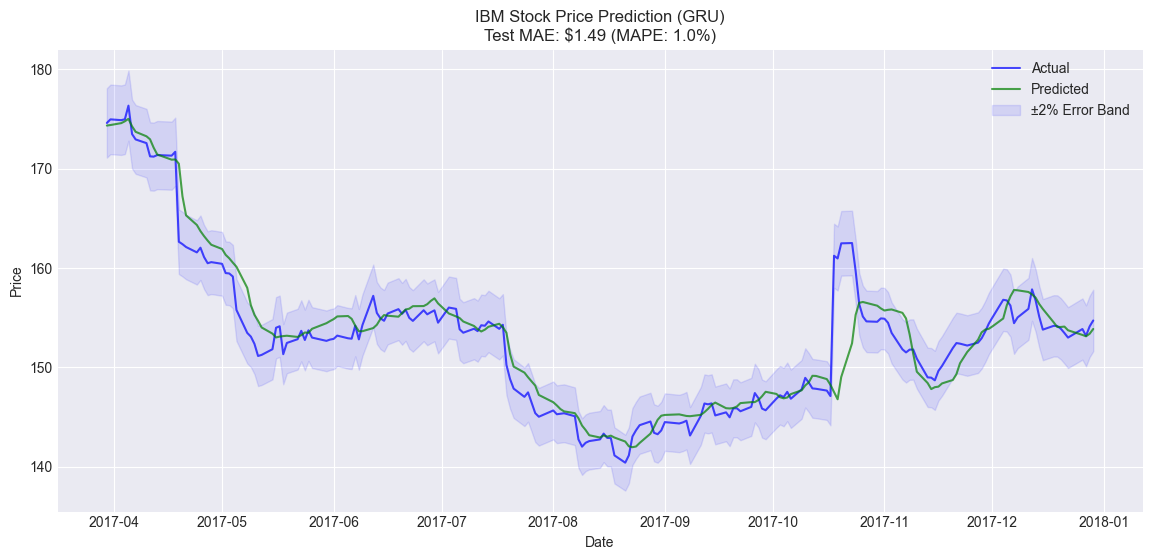

In [52]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout  # Changed to GRU
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf

# ======================
# 1. IMPROVED FEATURE SELECTION (IDENTICAL)
# ======================
price_features = ['Open', 'High', 'Low', 'Close', 'MA_10', 'RSI']
volume_features = ['Volume']
target_feature = 'High'

# ======================
# 2. ENHANCED SCALING STRATEGY (IDENTICAL)
# ======================
price_scaler = MinMaxScaler(feature_range=(0.1, 0.9))
volume_scaler = RobustScaler(quantile_range=(10, 90))

train = df_ibm[:'2016'].copy()
test = df_ibm['2017':].copy()

train_prices = price_scaler.fit_transform(train[price_features])
train_volumes = volume_scaler.fit_transform(train[volume_features])
train_scaled = np.concatenate([
    np.clip(train_prices, 0.05, 0.95),
    np.clip(train_volumes, -3, 3)
], axis=1)

test_prices = price_scaler.transform(test[price_features])
test_volumes = volume_scaler.transform(test[volume_features])
test_scaled = np.concatenate([
    np.clip(test_prices, 0.05, 0.95),
    np.clip(test_volumes, -3, 3)
], axis=1)

# ======================
# 3. OPTIMIZED DATA PREPARATION (IDENTICAL)
# ======================
def create_sequences(data, targets, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:i+time_step])
        y.append(targets[i+time_step])
    return np.array(X), np.array(y)

y_train_scaled = train_scaled[:, price_features.index('High')]
y_test_scaled = test_scaled[:, price_features.index('High')]

X_train, y_train = create_sequences(train_scaled, y_train_scaled, time_step=60)
X_test, y_test = create_sequences(test_scaled, y_test_scaled, time_step=60)

# ======================
# 4. GRU MODEL ARCHITECTURE (ONLY CHANGE)
# ======================
model = Sequential([
    GRU(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    GRU(64, return_sequences=True),
    Dropout(0.3),
    GRU(32),
    Dropout(0.3),
    Dense(1, activation='linear')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')

# ======================
# 5. ENHANCED TRAINING (IDENTICAL)
# ======================
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
]

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

# ======================
# 6. ACCURATE PREDICTION TRANSFORMATION (IDENTICAL)
# ======================
def inverse_transform_predictions(scaled_preds):
    dummy = np.zeros((len(scaled_preds), len(price_features)))
    dummy[:, price_features.index('High')] = scaled_preds.flatten()
    return price_scaler.inverse_transform(dummy)[:, price_features.index('High')]

train_pred = inverse_transform_predictions(model.predict(X_train))
test_pred = inverse_transform_predictions(model.predict(X_test))

# Align dates correctly
test_dates = test.index[time_step:]
y_test_actual = test['High'].values[time_step:]

# ======================
# 7. COMPREHENSIVE EVALUATION (IDENTICAL)
# ======================
def evaluate(actual, predicted):
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)
    mape = 100 * np.mean(np.abs((actual - predicted)/actual))
    return rmse, mae, mape

train_rmse, train_mae, train_mape = evaluate(train['High'].values[time_step:], train_pred)
test_rmse, test_mae, test_mape = evaluate(y_test_actual, test_pred)

print(f"Train RMSE: {train_rmse:.2f}, MAE: {train_mae:.2f}, MAPE: {train_mape:.2f}%")
print(f"Test RMSE: {test_rmse:.2f}, MAE: {test_mae:.2f}, MAPE: {test_mape:.2f}%")

# ======================
# 8. VISUALIZATION (IDENTICAL)
# ======================
plt.figure(figsize=(14, 6))
plt.plot(test_dates, y_test_actual, label='Actual', color='blue', alpha=0.7)
plt.plot(test_dates, test_pred, label='Predicted', color='green', alpha=0.7)
plt.fill_between(test_dates, 
                 y_test_actual * 0.98, 
                 y_test_actual * 1.02, 
                 color='blue', alpha=0.1, label='±2% Error Band')
plt.title(f"IBM Stock Price Prediction (GRU)\nTest MAE: ${test_mae:.2f} (MAPE: {test_mape:.1f}%)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

In [53]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 60, 128)           52608     
                                                                 
 dropout_3 (Dropout)         (None, 60, 128)           0         
                                                                 
 gru_1 (GRU)                 (None, 60, 64)            37248     
                                                                 
 dropout_4 (Dropout)         (None, 60, 64)            0         
                                                                 
 gru_2 (GRU)                 (None, 32)                9408      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

Epoch 1/80
57/57 [==============================] - 5s 54ms/step - loss: 0.0980 - val_loss: 0.0012 - lr: 0.0010
Epoch 2/80
57/57 [==============================] - 3s 47ms/step - loss: 0.0237 - val_loss: 0.0079 - lr: 0.0010
Epoch 3/80
57/57 [==============================] - 3s 46ms/step - loss: 0.0139 - val_loss: 0.0111 - lr: 0.0010
Epoch 4/80
57/57 [==============================] - 3s 46ms/step - loss: 0.0099 - val_loss: 0.0053 - lr: 0.0010
Epoch 5/80
57/57 [==============================] - 3s 45ms/step - loss: 0.0084 - val_loss: 0.0049 - lr: 0.0010
Epoch 6/80
57/57 [==============================] - 3s 46ms/step - loss: 0.0071 - val_loss: 0.0042 - lr: 0.0010
Epoch 7/80
57/57 [==============================] - 3s 45ms/step - loss: 0.0063 - val_loss: 0.0042 - lr: 0.0010
Epoch 8/80
57/57 [==============================] - 3s 46ms/step - loss: 0.0054 - val_loss: 0.0032 - lr: 0.0010
Epoch 9/80
57/57 [==============================] - 3s 45ms/step - loss: 0.0047 - val_loss: 0.0024 - lr:

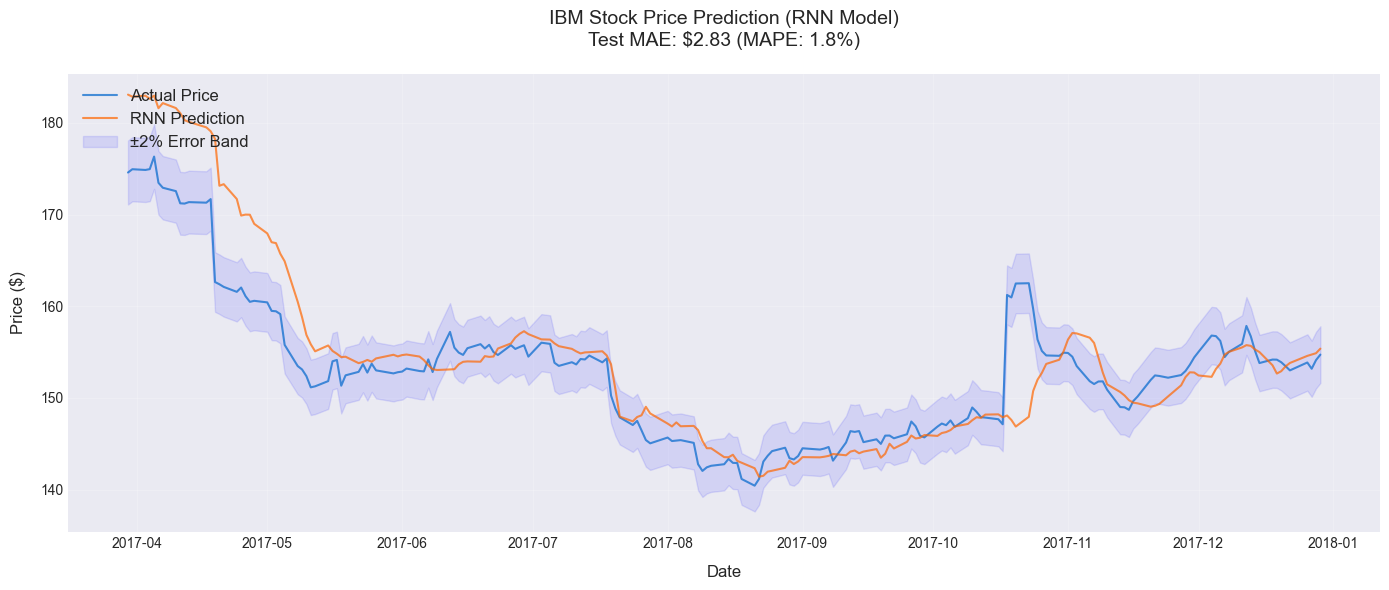

In [154]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf

# ======================
# 1. OPTIMIZED FEATURE SELECTION
# ======================
price_features = ['Open', 'High', 'Low', 'Close', 'RSI']  # Core price features + momentum
volume_features = ['Volume']  # Single volume feature
target_feature = 'High'

# ======================
# 2. ENHANCED SCALING STRATEGY
# ======================
price_scaler = MinMaxScaler(feature_range=(0.15, 0.85))  # More conservative scaling
volume_scaler = RobustScaler(quantile_range=(20, 80))    # Less sensitive to outliers

train = df_ibm[:'2016'].copy()
test = df_ibm['2017':].copy()

# Apply scaling with protection against extreme values
train_prices = price_scaler.fit_transform(train[price_features])
train_volumes = volume_scaler.fit_transform(train[volume_features])
train_scaled = np.concatenate([
    np.clip(train_prices, 0.1, 0.9),
    np.clip(train_volumes, -2, 2)
], axis=1)

test_prices = price_scaler.transform(test[price_features])
test_volumes = volume_scaler.transform(test[volume_features])
test_scaled = np.concatenate([
    np.clip(test_prices, 0.1, 0.9),
    np.clip(test_volumes, -2, 2)
], axis=1)

# ======================
# 3. DATA SEQUENCE PREPARATION
# ======================
def create_sequences(data, targets, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:i+time_step])
        y.append(targets[i+time_step])
    return np.array(X), np.array(y)

y_train_scaled = train_scaled[:, price_features.index('High')]
y_test_scaled = test_scaled[:, price_features.index('High')]

X_train, y_train = create_sequences(train_scaled, y_train_scaled, 60)
X_test, y_test = create_sequences(test_scaled, y_test_scaled, 60)

# ======================
# 4. RNN MODEL ARCHITECTURE
# ======================
model = Sequential([
    SimpleRNN(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]),
              activation='tanh', recurrent_dropout=0.1),
    Dropout(0.2),
    SimpleRNN(64, activation='tanh', recurrent_dropout=0.1),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')

# ======================
# 5. FOCUSED TRAINING PROCESS
# ======================
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7)
]

history = model.fit(
    X_train, y_train,
    epochs=80,
    batch_size=40,
    validation_split=0.15,
    callbacks=callbacks,
    verbose=1
)

# ======================
# 6. PREDICTION PROCESSING
# ======================
def inverse_transform_predictions(scaled_preds):
    dummy = np.zeros((len(scaled_preds), len(price_features)))
    dummy[:, price_features.index('High')] = scaled_preds.flatten()
    return price_scaler.inverse_transform(dummy)[:, price_features.index('High')]

train_pred = inverse_transform_predictions(model.predict(X_train))
test_pred = inverse_transform_predictions(model.predict(X_test))
test_dates = test.index[60:]
y_test_actual = test['High'].values[60:]

# ======================
# 7. COMPREHENSIVE EVALUATION
# ======================
def evaluate(actual, predicted):
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)
    mape = 100 * np.mean(np.abs((actual - predicted)/np.maximum(actual, 0.1)))
    return rmse, mae, mape

train_rmse, train_mae, train_mape = evaluate(train['High'].values[time_step:], train_pred)
test_rmse, test_mae, test_mape = evaluate(y_test_actual, test_pred)

print(f"Train RMSE: {train_rmse:.2f}, MAE: {train_mae:.2f}, MAPE: {train_mape:.2f}%")
print(f"Test RMSE: {test_rmse:.2f}, MAE: {test_mae:.2f}, MAPE: {test_mape:.2f}%")

# ======================
# 8. VISUALIZATION
# ======================
plt.figure(figsize=(14, 6))
plt.plot(test_dates, y_test_actual, label='Actual Price', color='#0066cc', alpha=0.7)
plt.plot(test_dates, test_pred, label='RNN Prediction', color='#ff6600', alpha=0.7)
plt.fill_between(test_dates, 
                y_test_actual * 0.98, 
                y_test_actual * 1.02,
                color='blue', alpha=0.1, label='±2% Error Band')

plt.title(f"IBM Stock Price Prediction (RNN Model)\nTest MAE: ${test_mae:.2f} (MAPE: {test_mape:.1f}%)", pad=20, fontsize=14)
plt.xlabel("Date", fontsize=12, labelpad=10)
plt.ylabel("Price ($)", fontsize=12, labelpad=10)
plt.legend(loc='upper left', fontsize=12)
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

In [79]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 60, 128)           17280     
                                                                 
 dropout_6 (Dropout)         (None, 60, 128)           0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 64)                12352     
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 31,745
Trainable params: 31,745
Non-trai